In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Big Picture Descriptives

In [25]:
# get all folders in a directory
f_1 = 'simg-b1710-s2023-02-15/'
folders = os.listdir(f_1)
df = pd.read_csv(f_1 + folders[0] + '/' + [i for i in os.listdir(f_1+ folders[0]) if i.endswith('.csv')][0])
for f_2 in folders[1:]:
    if (f_2 == '.DS_Store') | (f_2 == 'README.md') | (f_2 == 'search_records'):
        continue
    else:
        file = [i for i in os.listdir(f_1+ f_2) if i.endswith('.csv')][0]
        df_temp = pd.read_csv(f_1+ f_2 + '/' + file)
        df = pd.concat([df, df_temp], axis=0)

In [27]:
df['Date']

0      2009-12-21
1      2010-11-22
2      2012-08-28
3      2012-05-11
4      2012-08-10
          ...    
165    2020-12-06
166    2018-04-02
167    2019-01-21
168    2020-01-28
169    2021-08-21
Name: Date, Length: 13821, dtype: object

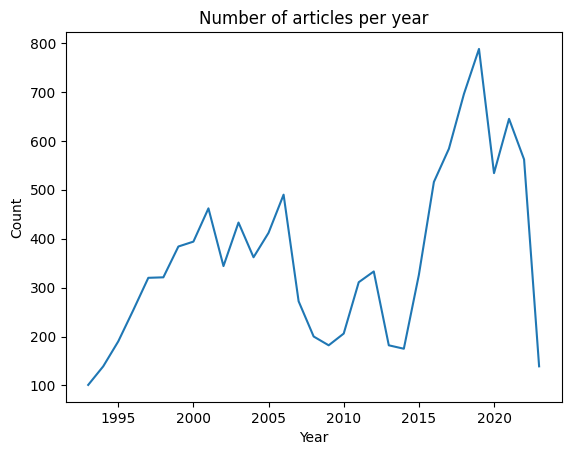

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
# plot the number of articles per year
df.groupby('Year').count()['Title'].plot(kind='line')

# Group by date and plot rolling average of sentiment over 30 days
df['Week'] = df['Date'].dt.week
df['Week'] = df['Week'].astype(str) + '-' + df['Year'].astype(str)
df['Week'] = pd.to_datetime(df['Week'], format='%W-%Y')
df['Week'] = df['Week'].dt.strftime('%Y-%m-%d')
df['Week'] = pd.to_datetime(df['Week'])


plt.title('Number of articles per year')
plt.ylabel('Count')
plt.show()

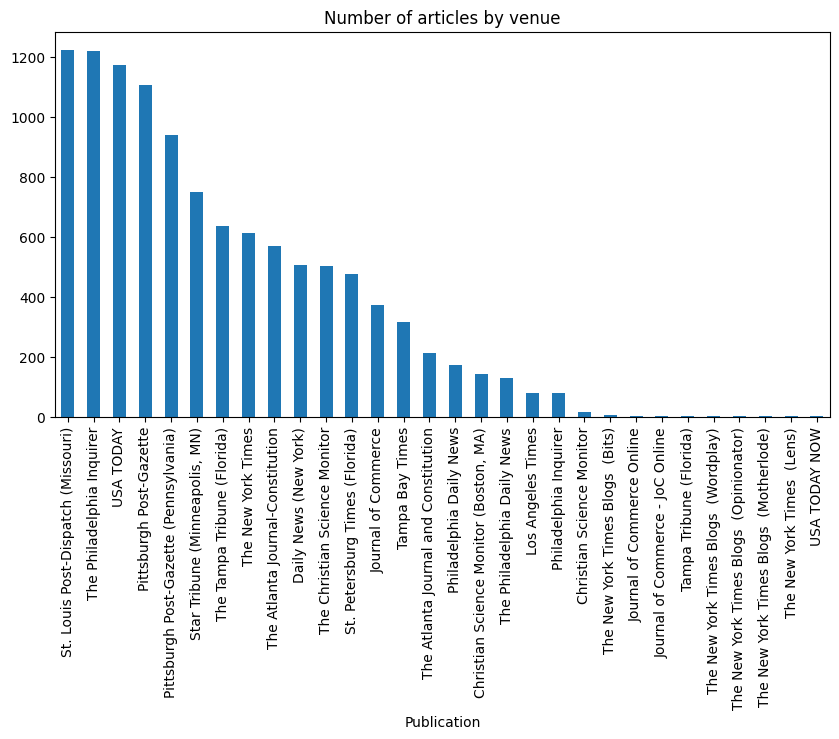

In [4]:
# set the figsize to be 10 by 5
plt.figure(figsize=(10,5))

# plot the number of articles by Publication, organized from highest to lowest
df.groupby('Publication').count()['Title'].sort_values(ascending=False).plot(kind='bar')

plt.title('Number of articles by venue')
plt.show()

In [5]:
# Some of the publications have different spellings, so we can use the replace method to replace the mispelled names with the correct names
# df.Publication.unique()

# Recode items in the Publication column to group together different spellings
df['Publication'] = df['Publication'].replace('Philadelphia Daily News', 'The Philadelphia Daily News') #'The Philadelphia Daily News', 'Philadelphia Daily News'
df['Publication'] = df['Publication'].replace('Pittsburgh Post-Gazette (Pennsylvania)','Pittsburgh Post-Gazette') # 'Pittsburgh Post-Gazette', 'Pittsburgh Post-Gazette (Pennsylvania)'
df['Publication'] = df['Publication'].replace('Journal of Commerce - JoC Online','Journal of Commerce') # 'Journal of Commerce Online', 'Journal of Commerce', 'Journal of Commerce - JoC Online'
df['Publication'] = df['Publication'].replace('Journal of Commerce Online','Journal of Commerce')
# Should we recode, or exclude the NYT blogs?
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Bits)','The New York Times') #'The New York Times','The New York Times Blogs  (Bits)','The New York Times Blogs  (Opinionator)','The New York Times  (Lens)','The New York Times Blogs  (Motherlode)','The New York Times Blogs  (Wordplay)',
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Opinionator)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times  (Lens)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Motherlode)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Wordplay)','The New York Times')

df['Publication'] = df['Publication'].replace('The Tampa Tribune (Florida)', 'Tampa Tribune (Florida)') #'The Tampa Tribune (Florida)', 'Tampa Tribune (Florida)',
df['Publication'] = df['Publication'].replace('The Atlanta Journal-Constitution', 'The Atlanta Journal and Constitution') #'The Atlanta Journal-Constitution', 'The Atlanta Journal and Constitution'

df['Publication'] = df['Publication'].replace('Christian Science Monitor (Boston, MA)','Christian Science Monitor')
df['Publication'] = df['Publication'].replace('The Christian Science Monitor','Christian Science Monitor')#'The Christian Science Monitor',  'Christian Science Monitor','Christian Science Monitor (Boston, MA)'

df['Publication'] = df['Publication'].replace('USA TODAY NOW','USA TODAY') #'USA Today Now', 'USA Today' #'USA Today Now', 'USA Today'
df['Publication'] = df['Publication'].replace('The Philadelphia Inquirer','Philadelphia Inquirer') #'USA Today Now', 'USA Today'

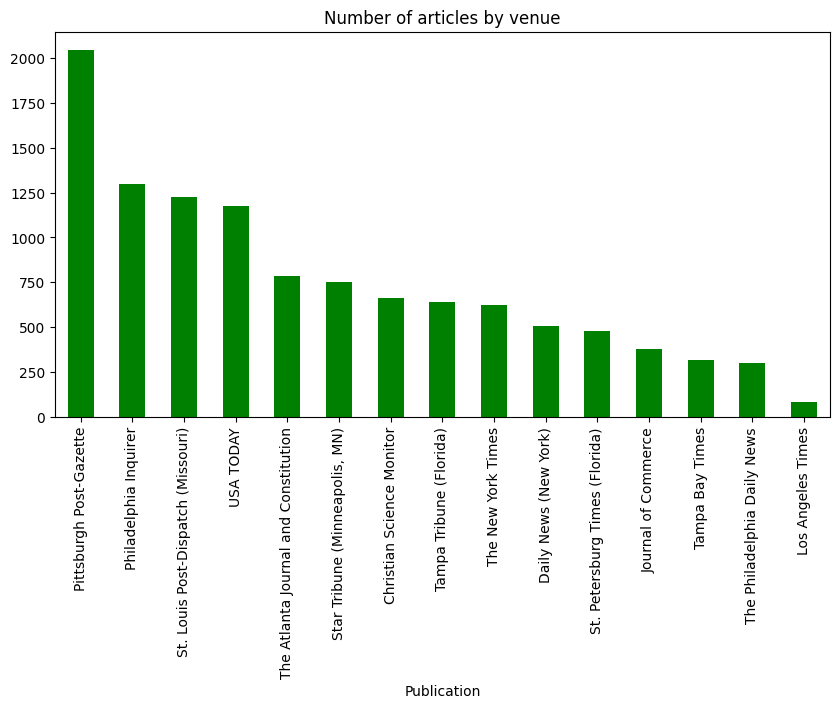

In [6]:

# set the figsize to be 10 by 5
plt.figure(figsize=(10,5))

# plot the number of articles by Publication, organized from highest to lowest
df.groupby('Publication').count()['Title'].sort_values(ascending=False).plot(kind='bar',color='green')

plt.title('Number of articles by venue')
plt.show()

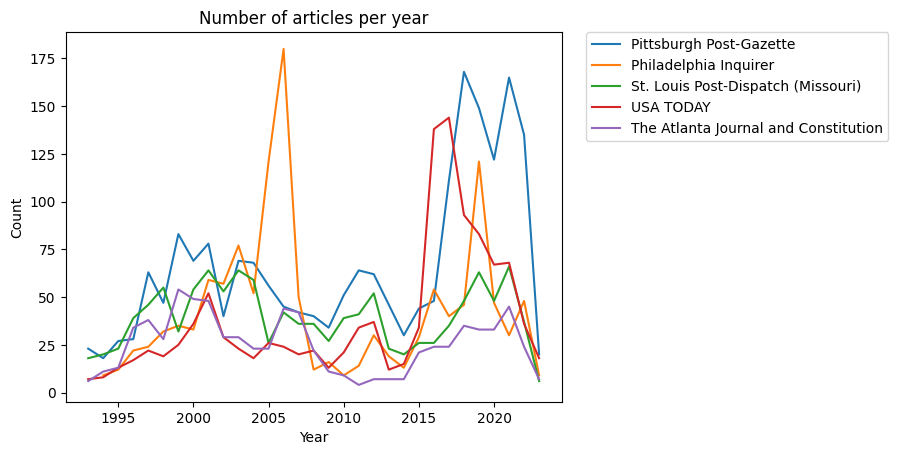

In [7]:
for p in df.groupby('Publication').count()['Title'].sort_values(ascending=False).index[:5]:
    df_temp = df.loc[df.Publication == p]
    df_temp.groupby('Year').count()['Title'].plot(kind='line', label=p)

plt.title('Number of articles per year')
plt.ylabel('Count')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

# Time to start analyzing some text

In [8]:
ai = ['artificial intelligence','machine learning']

file_name, n_words, text = [], [], []  

# Iterate through the files in each of the folders
def get_mentions(words):
    for f_2 in folders:
        if (f_2 == '.DS_Store') | (f_2 == 'README.md') | (f_2 == 'search_records'):
            continue
        else:
            for f_3 in os.listdir(f_1 + f_2 +'/plaintext/'):
                all_references = []
                with open(f_1 + f_2 + '/plaintext/' + f_3,'r') as f:

                    contents = f.read()

                    for word in words:
                        if word == 'AI':
                            locs = [m.start() for m in re.finditer(word, contents)]
                        else:
                            locs = [m.start() for m in re.finditer(word, contents,re.IGNORECASE)]
                        # collect the text surrounding the keywords
                        for i in locs:
                            if i < 70:
                                all_references.append(contents[:i+70])
                            elif i > len(contents)-70:
                                all_references.append(contents[i-70:])
                            else:
                                all_references.append(contents[i-70:i+70])
                file_name.append(f_3)
                n_words.append(len(contents.split()))
                text.append(all_references)
    return pd.DataFrame({'Filename':file_name, 'n_words':n_words, 'text':text})           



In [15]:
# Keywords related to healthcare:
ai = ['artificial intelligence','machine learning']
health_words = ['health','medicine','medical','hospital','doctor','nurse','diagnosis','prescription']
justice_words = ['justice','law','court','judge','attorney','lawyer','jury','trial','freedom']
education_words = ['education','school','student','teacher','lesson','teach']

df_references = get_mentions(health_words)


In [16]:
df_references = df_references.loc[df_references.text.apply(lambda x: len(x)) > 0] # returns an individual instance of the text

In [17]:
sent_get = SentimentIntensityAnalyzer()
def get_vaders(lot):
    if len(lot) == 0:
        return None
    else:
        return [sent_get.polarity_scores(i)['compound'] for i in lot]

In [21]:
df_references['vader'] = df_references.text.apply(get_vaders)
df_references['avg_vader'] = df_references.vader.apply(lambda x: np.mean(x) if x is not None else None)
df_references.drop_duplicates(subset=['Filename'],inplace=True)
df = df.merge(df_references[['Filename','avg_vader']],on='Filename',how='left')

In [23]:
# plot the average vader score by year with 95% confidence intervals
df_1 = df.dropna(subset =['avg_vader'])
df_1

,Filename,Publication,Section,Date,Title,Author,LNID,Year,avg_vader_x,avg_vader_y,avg_vader
1,the-philadelphia-daily-news-letters_-pennsylva...,The Philadelphia Daily News,EDITORIAL OPINION,2010-11-22,Letters: Pennsylvania Supreme Court Chief Just...,NaN,51HT-P8Y1-DYJT-23V3-00000-00,2010.0,NaN,0.0000,0.0000
2,the-philadelphia-daily-news-tattle_-katy-perry...,The Philadelphia Daily News,FEATURES,2012-08-28,Tattle: Katy Perry turns down a reported $20...,By Howard Gensler,56FB-R5D1-JC3R-B3RG-00000-00,2012.0,NaN,0.0000,0.0000
8,the-philadelphia-daily-news-high-schools---664...,The Philadelphia Daily News,SPORTS,2009-03-24,High Schools - Nasir Jones stellar in Public L...,By TED SILARY,7V96-1FF0-Y9F1-X3HH-00000-00,2009.0,0.8591,0.8591,0.8591
13,the-philadelphia-daily-news-the-shape-of-6653a...,The Philadelphia Daily News,FEATURES,2009-12-28,"The shape of slots to come: Think HD, big scre...",By CHUCK DARROW,7XDP-20M1-2R00-600V-00000-00,2009.0,0.7089,0.7089,0.7089
15,the-philadelphia-daily-news-letters_-solution-...,The Philadelphia Daily News,EDITORIAL OPINION,2009-11-24,Letters: Solution for Port Richmond abuses,NaN,7X5F-1T30-Y9F1-X4G9-00000-00,2009.0,NaN,0.8176,0.8176
...,...,...,...,...,...,...,...,...,...,...,...
13816,the-atlanta-journal-constitution-guest-column-...,The Atlanta Journal and Constitution,NEWS,2020-12-06,GUEST COLUMN How virus points way to faster fu...,Llewellyn King,61FT-C3J1-JC85-V01C-00000-00,2020.0,0.8126,0.8126,0.8126
13817,the-atlanta-journal-constitution-ajc-exclusive...,The Atlanta Journal and Constitution,METRO,2018-04-02,AJC EXCLUSIVE STARTUPS Goldman Sachs joins fun...,J. Scott Trubey,5S11-5BM1-DYR7-J008-00000-00,2018.0,0.8020,0.8020,0.8020
13818,the-atlanta-journal-constitution-only-in-the-3...,The Atlanta Journal and Constitution,NEWS,2019-01-21,"ONLY IN THE AJC KING DAY On MLK's birthday, fr...",Ernie Suggs and Rosalind Bentley,5V7P-RX91-JC85-V42R-00000-00,2019.0,NaN,0.6369,0.6369
13819,the-atlanta-journal-constitution-ajc-exclusive...,The Atlanta Journal and Constitution,METRO,2020-01-28,"AJC EXCLUSIVE In an uncertain world, let kids ...",Maureen Downey Only in the AJC,5Y31-X8V1-JC85-V194-00000-00,2020.0,0.6070,0.6070,0.6070


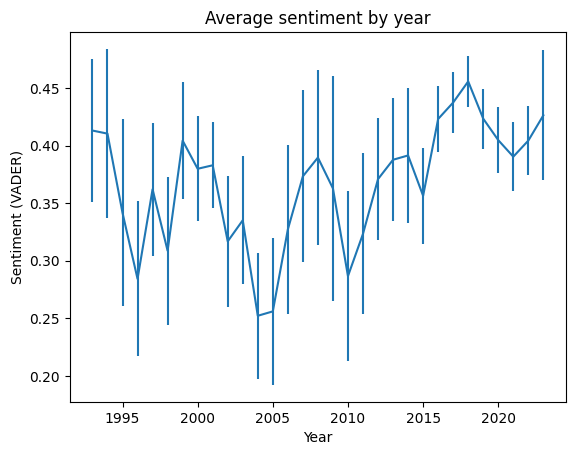

In [24]:
# Plot the average vader score by year
df.groupby('Year').mean()['avg_vader'].plot(kind='line',yerr=df.groupby('Year').std()['avg_vader']*1.96/np.sqrt(df.groupby('Year').count()['avg_vader']))
plt.title('Average sentiment by year')
plt.ylabel('Sentiment (VADER)')
plt.show()

In [67]:
# We can use statistical techniques to identify emergent keywords
# import the necessary packages
import yake
import re

kw_extractor = yake.KeywordExtractor()
keywords = kw_extractor.extract_keywords(contents)
# identify keywords in text

,Filename,Publication,Section,Date,Title,Author,LNID,Year
0,the-philadelphia-daily-news-drexel-will-run-66...,The Philadelphia Daily News,SPORTS,2009-12-21,Drexel will run into Kentucky's Wall,By MIKE MAZZEO,7XC6-7S11-2R00-6367-00000-00,2009.0
1,the-philadelphia-daily-news-letters_-pennsylva...,The Philadelphia Daily News,EDITORIAL OPINION,2010-11-22,Letters: Pennsylvania Supreme Court Chief Just...,NaN,51HT-P8Y1-DYJT-23V3-00000-00,2010.0
2,the-philadelphia-daily-news-tattle_-katy-perry...,The Philadelphia Daily News,FEATURES,2012-08-28,Tattle: Katy Perry turns down a reported $20...,By Howard Gensler,56FB-R5D1-JC3R-B3RG-00000-00,2012.0
3,the-philadelphia-daily-news-publics-go-to-6645...,The Philadelphia Daily News,WEB,2012-05-11,Publics go to town in Eagles City All-Star Foo...,BY TED SILARY,55M3-X631-DYJT-221T-00000-00,2012.0
4,the-philadelphia-daily-news-director-alison-kl...,The Philadelphia Daily News,ENTERTAINMENT,2012-08-10,Director Alison Klayman profiles Chinese activ...,By Molly EichelDaily News Staff Writer,569H-7WT1-DYJT-2041-00000-00,2012.0
...,...,...,...,...,...,...,...,...
165,the-atlanta-journal-constitution-guest-column-...,The Atlanta Journal and Constitution,NEWS,2020-12-06,GUEST COLUMN How virus points way to faster fu...,Llewellyn King,61FT-C3J1-JC85-V01C-00000-00,2020.0
166,the-atlanta-journal-constitution-ajc-exclusive...,The Atlanta Journal and Constitution,METRO,2018-04-02,AJC EXCLUSIVE STARTUPS Goldman Sachs joins fun...,J. Scott Trubey,5S11-5BM1-DYR7-J008-00000-00,2018.0
167,the-atlanta-journal-constitution-only-in-the-3...,The Atlanta Journal and Constitution,NEWS,2019-01-21,"ONLY IN THE AJC KING DAY On MLK's birthday, fr...",Ernie Suggs and Rosalind Bentley,5V7P-RX91-JC85-V42R-00000-00,2019.0
168,the-atlanta-journal-constitution-ajc-exclusive...,The Atlanta Journal and Constitution,METRO,2020-01-28,"AJC EXCLUSIVE In an uncertain world, let kids ...",Maureen Downey Only in the AJC,5Y31-X8V1-JC85-V194-00000-00,2020.0
